In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import gzip
import grader
from tqdm import tqdm_notebook
import sklearn.linear_model
import sklearn.metrics
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import md5, sha

# Time Series Data: Predict Temperature
Time series prediction presents its own challenges which are different from machine-learning problems.  As with many other classes of problems, there are a number of common features in these predictions.

## A note on scoring
It **is** possible to score >1 on these questions. This indicates that you've beaten our reference model - we compare our model's score on a test set to your score on a test set. See how high you can go!

## Fetch the data:

In [4]:
!aws s3 sync s3://dataincubator-course/mldata/ . --exclude '*' --include 'train.txt.gz'

The columns of the data correspond to the
  - year
  - month
  - day
  - hour
  - temp
  - dew_temp
  - pressure
  - wind_angle
  - wind_speed
  - sky_code
  - rain_hour
  - rain_6hour
  - city

This function will read the data from a file handle into a Pandas DataFrame.  Feel free to use it, or to write your own version to load it in the format you desire.

In [5]:
def load_stream(stream):
    return pd.read_table(stream, sep=' *', engine='python',
                         names=['year', 'month', 'day', 'hour', 'temp',
                                'dew_temp', 'pressure', 'wind_angle', 
                                'wind_speed', 'sky_code', 'rain_hour',
                                'rain_6hour', 'city'])

In [6]:
df = load_stream(gzip.open('train.txt.gz', 'r'))

In [7]:
# df

The temperature is reported in tenths of a degree Celcius.  However, not all the values are valid.  Examine the data, and remove the invalid rows.

In [8]:
# tempsort = df.sort_values(by=['temp'])

In [9]:
# tempsort

In [10]:
df = df[df.temp >= -500]

In [11]:
df = df[df.temp <= 400]

In [12]:
import datetime
x = datetime.date(2007,10,12)
x
# datetime.datetime(2007,10,12).toordinal() -- 1 way to do Julian day

datetime.date(2007, 10, 12)

In [13]:
from matplotlib.dates import date2num
x = datetime.date(2007,10,12)
matplotlib.dates.date2num(x)

#preferred way to do Julian day if plotting in Matplotlib

732961.0

In [14]:
# df['date'] = df['date'].astype('datetime64[D]')
# df['Julian'] = matplotlib.dates.date2num(df['date'])

df['date'] = pd.to_datetime(df[['year', 'month', 'day']])  
# ^^creates new column with date 

# df['Julian'] = df['date'].dt.strftime('%y%j.0') 
# -- 2nd way to get Julian
# df

In [15]:
df['Julian'] = matplotlib.dates.date2num(list(df['date']))
df

#argh finally worked!! just added "list" in front of df['date']. Now I can
# get the matplotlib plot going! turn a series into a list to 
# make date2num work.

,year,month,day,hour,temp,dew_temp,pressure,wind_angle,wind_speed,sky_code,rain_hour,rain_6hour,city,date,Julian
0,2000,1,1,0,-11,-72,10197,220,26,4,0,0,bos,2000-01-01,730120.0
1,2000,1,1,1,-6,-78,10206,230,26,2,0,-9999,bos,2000-01-01,730120.0
2,2000,1,1,2,-17,-78,10211,230,36,0,0,-9999,bos,2000-01-01,730120.0
3,2000,1,1,3,-17,-78,10214,230,36,0,0,-9999,bos,2000-01-01,730120.0
4,2000,1,1,4,-17,-78,10216,230,36,0,0,-9999,bos,2000-01-01,730120.0
5,2000,1,1,5,-22,-78,10218,230,36,0,0,-9999,bos,2000-01-01,730120.0
6,2000,1,1,6,-28,-83,10219,230,26,0,0,0,bos,2000-01-01,730120.0
7,2000,1,1,7,0,-78,10222,280,46,0,0,-9999,bos,2000-01-01,730120.0
8,2000,1,1,8,-11,-72,10231,240,36,7,0,-9999,bos,2000-01-01,730120.0
9,2000,1,1,9,-28,-78,10228,230,41,0,0,-9999,bos,2000-01-01,730120.0


In [16]:
df[['month','temp']].set_index('date').plot()

KeyError: 'date'

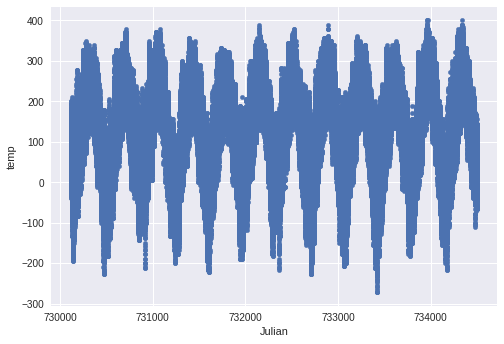

In [17]:
df.plot('Julian','temp','scatter') 
# replace first term (month) with new Julian number 
# after recalc

We will focus on using the temporal elements to predict the temperature.

## Per city model

It makes sense for each city to have it's own model.  Build a "groupby" estimator that takes an estimator factory as an argument and builds the resulting "groupby" estimator on each city.  That is, `fit` should create and fit a model per city, while the `predict` method should look up the corresponding model and perform a predict on each.  An estimator factory is something that returns an estimator each time it is called.  It could be a function or a class.

In [18]:
from sklearn import base

class GroupbyEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, column, estimator_factory):
        # column is the value to group by; estimator_factory can be
        # called to produce estimators
        self.estimators = {}
        self.col_name = column
        self.estimator = estimator_factory()
    
    def fit(self, X, y):
        # Create an estimator and fit it with the portion in each group, eg city
        gb = X.groupby(by=self.col_name)
        self.groups = gb.groups
        for group_name, _ in self.groups.iteritems():
            group = gb.get_group(group_name)
            #print type(self.estimator), self.estimator
            estim = self.estimator.fit(group[['month','hour']], group['temp'])
            self.estimators[group_name] = estim
        return self
    
    def chop_grader_input_to_month_and_hour(self, s):
        info = s.split()
        #print len(info), info
        temp = (int(info[1]), int(info[3]), info[-1])
        #print temp
        return temp
        
    def predict(self, X):
        preds = []
        for row in tqdm_notebook(X):
            #print "looping once"
            foo = self.chop_grader_input_to_month_and_hour(row)
            #print foo
            bar = self.estimators[foo[2]].predict([foo[0], foo[1]])
            #print bar[0]
            preds.append(bar[0])
        return preds

# Questions

For each question, build a model to predict the temperature in a given city at a given time.  You will be given a list of records, each a string in the same format as the lines in the training file.  Return a list of predicted temperatures, one for each incoming record.  (As you can imagine, the temperature values will be stripped out in the actual text records.)

## month_hour_model
Seasonal features are nice because they are relatively safe to extrapolate into the future. There are two ways to handle seasonality.  

The simplest (and perhaps most robust) is to have a set of indicator variables. That is, make the assumption that the temperature at any given time is a function of only the month of the year and the hour of the day, and use that to predict the temperature value.

**Question**: Should month be a continuous or categorical variable?  (Recall that [one-hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) is useful to deal with categorical variables.)

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
def season_factory():
    return RandomForestRegressor()


In [21]:
season_model = GroupbyEstimator('city', season_factory).fit(df, df['temp'])

You will need to write a function that makes predictions from a list of strings.  You can either create a pipeline with a transformer and the `season_model`, or you can write a helper function to convert the lines to the format you expect.

In [22]:
# grader.score('ts__month_hour_model', season_model.predict)

HBox(children=(IntProgress(value=0, max=42463), HTML(value=u'')))

KeyboardInterrupt: 

## fourier_model
Since we know that temperature is roughly sinusoidal, we know that a reasonable model might be

$$ y_t = y_0 \sin\left(2\pi\frac{t - t_0}{T}\right) + \epsilon $$

where $k$ and $t_0$ are parameters to be learned and $T$ is one year for seasonal variation.  While this is linear in $y_0$, it is not linear in $t_0$. However, we know from Fourier analysis, that the above is
equivalent to

$$ y_t = A \sin\left(2\pi\frac{t}{T}\right) + B \cos\left(2\pi\frac{t}{T}\right) + \epsilon $$

which is linear in $A$ and $B$.

Create a model containing sinusoidal terms on one or more time scales, and fit it to the data using a linear regression.


Grader: Is looking for list of predicted temps from the raw data (stick the list object in the lambda)

## 3/2/18 Notes with Rich: 
### TS: 
AM_Time Series (<See notebook: above for code on how to do this)

Lecture - 2/1/18 18:19

Play with linear regressions to emulate waves! (Wolfram alpha)
Good explanation here: https://www.mathworks.com/help/signal/ug/frequency-domain-linear-regression.html


"The parameters of the model are the overall mean and the amplitudes of the cosines and sines. The model is linear in the parameters.

To construct a linear regression model in the time domain, you have to specify which frequencies to use for the cosines and sines, form the design matrix, and solve the normal equations in order to obtain the least-squares estimates of the model parameters. In this case, it is easier to use the discrete Fourier transform to detect the periodicities, retain only a subset of the Fourier coefficients, and invert the transform to obtain the fitted time series.

Perform a spectral analysis of the data to reveal which frequencies contribute significantly to the variability in the data. "
https://www.youtube.com/watch?v=cz4onDdCCdY
https://math.stackexchange.com/questions/140788/how-is-the-fourier-transform-linear

—
Cos is L-R
Sun is up-down

Y = temp
Mx +
B
Create Julian Day 

^^ Come up with the linear model, fiddle with below. Make sure to add a date column based on Julian Day (don't use .JulianDay bc it won't get plotted, find another way). Then give a list of predicted temps based on the raw data to the lambda fx in grader.

### Spark: 
Don't be intimidated by huge error messages, just go from the bottom up. Change the file format and add "> /dev/null " [as in -- $ spark-submit ratings-counter.py 2> /dev/null] so you don't get the huge messages just the results.

### Capstone: 
Add a linear function to Flask, and it should work. (see notebook for expit, etc)


In [23]:
# Create a model containing sinusoidal terms on one or more time scales, 
# and fit it to the data using a linear regression.

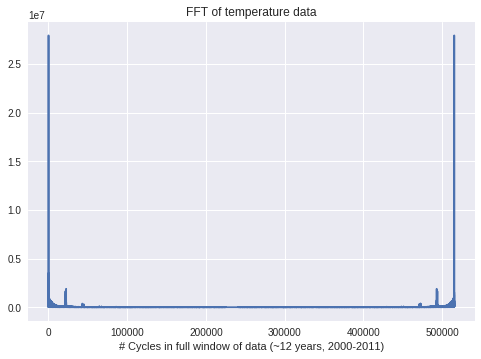

In [24]:
from scipy import fftpack

fft = fftpack.fft(df.temp - df.temp.mean())
plt.plot(np.abs(fft))
plt.title("FFT of temperature data")
plt.xlabel('# Cycles in full window of data (~12 years, 2000-2011)')

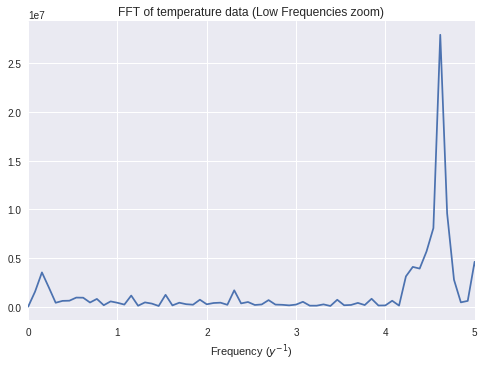

In [25]:
plt.plot(1./13 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of temperature data (Low Frequencies zoom)")
plt.xlim([0,5])
plt.xlabel('Frequency ($y^{-1}$)')

In [26]:
# df['Julian'] = df.date.to_julian_date()

df['const'] = 1
df['sin(year)'] = np.sin(df['Julian'] / 365.25 * 2 * np.pi)
df['cos(year)'] = np.cos(df['Julian'] / 365.25 * 2 * np.pi)
df['sin(6mo)'] = np.sin(df['Julian'] / (365.25 / 2) * 2 * np.pi)
df['cos(6mo)'] = np.cos(df['Julian'] / (365.25 / 2) * 2 * np.pi)
df['sin(day)'] = np.sin(df['hour'] / 24.0 * 2* np.pi)
df['cos(day)'] = np.cos(df['hour'] / 24.0 * 2* np.pi)

In [27]:
df['temp'].head()

0   -11
1    -6
2   -17
3   -17
4   -17
Name: temp, dtype: int64

In [28]:
df['temp'].shift(-1).head()

0    -6.0
1   -17.0
2   -17.0
3   -17.0
4   -22.0
Name: temp, dtype: float64

In [29]:
df['Goal'] = df['temp'].shift(-24)

1512.13299204


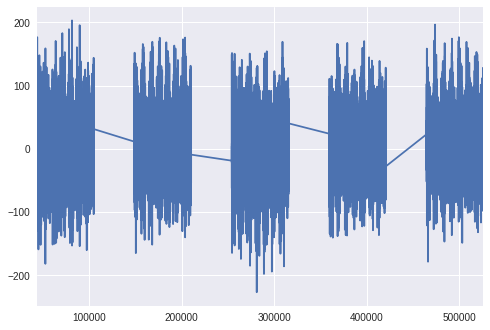

In [30]:
cut_year = 2005
train = df[df.year < cut_year].dropna(how='any')
test = df[df.year >= cut_year].dropna(how='any')

regress = sklearn.linear_model.LinearRegression().fit(
     X = train[['temp', 'sin(year)','cos(year)', 'sin(day)', 'cos(day)']], 
     y = train['Goal'])
    
test['Predicted_Value'] = regress.predict(X = test[['temp', 'sin(year)','cos(year)', 'sin(day)', 'cos(day)']] )

(test['Goal'] - test['Predicted_Value']).plot()
print sklearn.metrics.mean_squared_error(test['Goal'], test['Predicted_Value'])


In [31]:
grader.score('ts__fourier_model', season_model.predict)

HBox(children=(IntProgress(value=0, max=42463), HTML(value=u'')))

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/opt/conda/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/opt/conda/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Your score:  0.948697959031


In [ ]:
# grader.score('ts__fourier_model', lambda x: [0] * len(x)

*Copyright &copy; 2016 The Data Incubator.  All rights reserved.*